# LitBank Named Entity Recognition: Embedding Comparison

This notebook contains the following steps:
1. Loading and exploring the LitBank dataset
2. Data preprocessing and flattening for NER
3. Loading pre-trained GloVe embeddings
4. Building BiLSTM models with different embeddings (random vs GloVe)
5. Training and evaluation
6. Performance comparison and analysis

**Dataset**: LitBank - annotated literary texts with entity labels

**Research Question**: How do different word embeddings affect BiLSTM performance on literary NER?

**Note**: This version compares:
- **Random embeddings**: Randomly initialized, learned from scratch
- **GloVe embeddings**: Pre-trained on Common Crawl (840B tokens)

## 1. Setup and Imports

In [1]:
# Import PyTorch for deep learning
import torch  # Main PyTorch library
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import Dataset, DataLoader  # Data handling utilities

# Import scientific computing libraries
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis

# Import visualization libraries
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualizations

# Import machine learning utilities
from sklearn.model_selection import train_test_split  # Data splitting

# Import NER evaluation metrics (specialized for sequence labeling)
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

# Import standard Python libraries
from collections import Counter  # Count occurrences
from tqdm.auto import tqdm  # Progress bars
import os  # Operating system utilities
import json  # JSON file handling

# Set random seeds for reproducibility (ensures same results each run)
torch.manual_seed(42)  # PyTorch random seed
np.random.seed(42)  # NumPy random seed

# Check if GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, otherwise CPU
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")  # Print GPU name
    print(f"CUDA Version: {torch.version.cuda}")  # Print CUDA version

Using device: cpu


## 2. Load LitBank Dataset

LitBank is loaded from Hugging Face. It contains literary texts annotated with:
- Named entities (PER, LOC, FAC, GPE, VEH, ORG)
- Coreference chains
- Events

In [2]:
# Import the datasets library from Hugging Face
from datasets import load_dataset

# Load LitBank dataset from Hugging Face
try:
    # Load the dataset with split_0 configuration
    dataset = load_dataset("coref-data/litbank_raw", "split_0")
    print("LitBank dataset loaded successfully!")
    # Display the dataset structure (train/validation/test splits)
    print(f"Dataset structure: {dataset}")
except Exception as e:
    # If loading fails, print error message
    print(f"Error loading dataset: {e}")
    print("You may need to download LitBank manually from https://github.com/dbamman/litbank")

LitBank dataset loaded successfully!
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes'],
        num_rows: 10
    })
    test: Dataset({
        features: ['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes'],
        num_rows: 10
    })
})


## 3. Understanding the Dataset Structure

LitBank has a nested structure. The following cells explore the structure and analyse the contents
* there are 100 rows, each corresponding to a separate literary work from 1719 to 1922 (for complete list see https://github.com/dbamman/litbank)
* the dataset contains an extract of ~2000 tokens per book, the number of sentences varies according to the sentence length (see sentence length analysis below)
* the total annotated dataset contains 210,532 tokens

In [3]:
# DOCUMENT-LEVEL VIEW: Show all features from first 5 documents in a table
print("=" * 80)
print("DOCUMENT-LEVEL OVERVIEW - ALL FEATURES")
print("=" * 80)

# Convert first 5 documents to DataFrame
df_docs = pd.DataFrame(dataset['train'][:5])
df_docs

DOCUMENT-LEVEL OVERVIEW - ALL FEATURES


,doc_name,meta_info,sentences,coref_chains,entities,events,original_text,quotes
0,2489_moby_dick,"{'author': 'Melville, Herman', 'date': '1851',...","[[CHAPTER, 1, Loomings, Call, me, Ishmael, .],...","[[[0, 4, 4], [0, 5, 5], [1, 16, 16], [1, 24, 2...","[[{'bio_tags': ['O', 'O', 'O', 'O', ''], 'toke...","[[{'is_event': False, 'token': 'CHAPTER'}, {'i...",CHAPTER 1\n\n Loomings\n\n\n\nCall me Ishmae...,[]
1,145_middlemarch,"{'author': 'Eliot, George', 'date': '1871', 'g...","[[BOOK, I., MISS, BROOKE, .], [CHAPTER, I., "",...","[[[0, 2, 3], [3, 0, 1], [4, 0, 0], [4, 9, 9], ...","[[{'bio_tags': ['O', 'O', 'O', 'O', ''], 'toke...","[[{'is_event': False, 'token': 'BOOK'}, {'is_e...",BOOK I.\n\nMISS BROOKE.\n\n\n\nCHAPTER I.\n\n ...,[{'attribution': 'an_amiable_handsome_baronet-...
2,11231_bartleby_the_scrivener_a_story_of_wallst...,"{'author': 'Melville, Herman', 'date': '1853',...","[[I, am, a, rather, elderly, man, .], [The, na...","[[[0, 0, 0], [1, 3, 3], [1, 12, 12], [1, 37, 3...","[[{'bio_tags': ['O', 'O', 'O', 'O', ''], 'toke...","[[{'is_event': False, 'token': 'I'}, {'is_even...",I am a rather elderly man. The nature of my a...,"[{'attribution': 'Turkey-28', 'end': {'sent_id..."
3,434_the_circular_staircase,"{'author': 'Rinehart, Mary Roberts', 'date': '...","[[CHAPTER, I, I, TAKE, A, COUNTRY, HOUSE, This...","[[[0, 2, 2], [0, 13, 15], [0, 17, 17], [0, 21,...","[[{'bio_tags': ['O', 'O', 'O', 'O', ''], 'toke...","[[{'is_event': False, 'token': 'CHAPTER'}, {'i...",CHAPTER I\n\nI TAKE A COUNTRY HOUSE\n\nThis is...,"[{'attribution': 'narrator-0', 'end': {'sent_i..."
4,2005_piccadilly_jim,"{'author': 'Wodehouse, P. G. (Pelham Grenville...","[[CHAPTER, I, A, RED-HAIRED, GIRL, The, reside...","[[[0, 2, 4]], [[0, 8, 10], [5, 22, 23], [6, 7,...","[[{'bio_tags': ['O', 'O', 'O', 'O', ''], 'toke...","[[{'is_event': False, 'token': 'CHAPTER'}, {'i...",CHAPTER I\n\nA RED-HAIRED GIRL\n\nThe residenc...,"[{'attribution': 'Mr__Peter_Pett-2', 'end': {'..."


In [4]:
# Explore the first example in the training set
if 'train' in dataset and len(dataset['train']) > 0:
    # Get the first sample from training data
    sample = dataset['train'][0]
    
    # Print all available keys (fields) in the sample
    print("Available fields in each document:")
    print(list(sample.keys()))
    
    # Show the structure of sentences (nested list)
    print("\n" + "="*60)
    print("SENTENCES structure:")
    print(f"Number of sentences in first document: {len(sample['sentences'])}")
    print(f"First sentence tokens: {sample['sentences'][0]}")
    print(f"Second sentence tokens: {sample['sentences'][1]}")
    
    # Show the structure of entities (nested list with dicts)
    print("\n" + "="*60)
    print("ENTITIES structure:")
    print(f"Number of entity lists: {len(sample['entities'])}")
    print(f"Entities in first sentence: {sample['entities'][0][:5]}")  # Show first 5 entities
    
    # Explain the structure
    print("\n" + "="*60)
    print("STRUCTURE EXPLANATION:")
    print("- Each document contains multiple sentences")
    print("- sentences[i] = list of tokens in sentence i")
    print("- entities[i] = list of entity dicts for sentence i")
    print("- Each entity dict has: 'token' (word) and 'bio_tags' (NER labels)")
    print("- bio_tags can be: 'O' (not an entity) or 'B-TYPE', 'I-TYPE' (entity)")
else:
    print("No training data available")

Available fields in each document:
['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes']

SENTENCES structure:
Number of sentences in first document: 94
First sentence tokens: ['CHAPTER', '1', 'Loomings', 'Call', 'me', 'Ishmael', '.']
Second sentence tokens: ['Some', 'years', 'ago', '--', 'never', 'mind', 'how', 'long', 'precisely', '--', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', ',', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', ',', 'I', 'thought', 'I', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', '.']

ENTITIES structure:
Number of entity lists: 94
Entities in first sentence: [{'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': 'CHAPTER'}, {'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': '1'}, {'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': 'Loomings'}, {'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': 'Call'}, {'bio_tags': ['O', 'O', 'O', 

For this project, coreference chains and events are not relevant, only the NER tags (`entities`).

Every token has a NER tag that is either 0 (no recognised entity) or one of 6 entities: 
* Person
* Location
* Facility
* Geopolitical entity
* Vehicle
* Organisation

NB: the annotation allows for nested entities, i.e. one token can be part of several entities (e.g. in `Mary's house` the token `Mary` would be a PER as well as part of an entity LOC). For each token there is a dictionary containing the token itself and the `bio_tags`for several annotation levels. 
* Layer 0 is used for primary annotation (13.7% of tokens).
* Layers 1-2 show nested entity annotations (fairly common, 6% of tokens).
* Layer 3 shows deep nesting (very rare - only 0.1% of tokens).
* Layer 4 is never used in this dataset.

For simplicity in this notebook only the first layer of annotation is used for training. It is true that some of the annotation information is lost. In a more sophisticated approach it would be necessary to use all layers or combine them into  a richer annotation scheme.

## 4. Flatten Dataset Structure

The model needs flat lists of tokens and tags. The following function will convert LitBank's nested structure into sentence-level examples.

**Input**: Nested structure, organised by document. The tokens are in feature `sentences` the NER tags in the feature `entities`.  
**Output**: Each sentence becomes its own example with a flat structure (`tokens` + `ner_tags`). Each token has exactly one tag (only layer 0 is used, see above)

In [5]:
def flatten_litbank_data(dataset_split):
    """
    Convert LitBank's nested structure to flat sentence-level examples.
    
    Input: Dataset with nested sentences and entities per document
    Output: List of dicts with 'tokens' and 'ner_tags' per sentence
    """
    flattened_examples = []  # Store all flattened sentences here
    
    # Loop through each document in the dataset
    for doc_idx, example in enumerate(dataset_split):
        # Get all sentences in this document (list of token lists)
        sentences = example.get('sentences', [])
        # Get all entities in this document (list of entity lists per sentence)
        entities = example.get('entities', [])
        
        # Process each sentence in the document
        for sent_idx, sentence_tokens in enumerate(sentences):
            # Skip empty sentences
            if not sentence_tokens:
                continue
            
            # Get entities for this specific sentence, entities are aligned with sentences (entities[i] corresponds to sentences[i])
            sent_entities = entities[sent_idx] if sent_idx < len(entities) else []
            
            # Create a mapping from token to its NER tag, each token in sentence_tokens needs a corresponding tag
            token_to_tag = {}  # Dictionary: token_index -> NER tag
            
            # Process each entity in this sentence
            for entity_dict in sent_entities:
                # Each entity has 'token' (the word) and 'bio_tags' (its NER label, layer 0)
                token = entity_dict.get('token', '')
                bio_tags = entity_dict.get('bio_tags', [])
                
                # bio_tags can be a list (for multi-word entities) or single string
                if isinstance(bio_tags, list) and len(bio_tags) > 0:
                    # Take the first tag if it's a list
                    tag = bio_tags[0] if bio_tags[0] else 'O'
                elif isinstance(bio_tags, str):
                    # Use the tag directly if it's a string
                    tag = bio_tags if bio_tags else 'O'
                else:
                    # Default to 'O' (outside entity) if no tag
                    tag = 'O'
                
                # Find this token in the sentence and record its tag
                # We search for the token's position to align it
                for token_idx, sent_token in enumerate(sentence_tokens):
                    # If token matches and hasn't been tagged yet
                    if sent_token == token and token_idx not in token_to_tag:
                        token_to_tag[token_idx] = tag
                        break  # Found it, move to next entity
            
            # Create the final list of tags aligned with tokens, any token not in token_to_tag gets 'O' (outside entity)
            ner_tags = [token_to_tag.get(i, 'O') for i in range(len(sentence_tokens))]
            
            # Add this sentence as a flat example
            flattened_examples.append({
                'tokens': sentence_tokens,  # List of words
                'ner_tags': ner_tags,  # List of NER labels (same length)
                'doc_idx': doc_idx,  # Track which document it came from
                'sent_idx': sent_idx  # Track which sentence in the document
            })
    
    return flattened_examples

# Flatten all dataset splits
train_data = flatten_litbank_data(dataset['train'])  # Flatten training data
val_data = flatten_litbank_data(dataset['validation'])  # Flatten validation data
test_data = flatten_litbank_data(dataset['test'])  # Flatten test data

# Print statistics
print(f"\nFlattened data statistics:")
print(f"Training sentences: {len(train_data)}")
print(f"Validation sentences: {len(val_data)}")
print(f"Test sentences: {len(test_data)}")

# Show an example
print(f"\nExample sentence:")
print(f"Tokens: {train_data[0]['tokens'][:15]}...")  # First 15 tokens
print(f"Tags:   {train_data[0]['ner_tags'][:15]}...")  # Corresponding tags


Flattened data statistics:
Training sentences: 6755
Validation sentences: 927
Test sentences: 880

Example sentence:
Tokens: ['CHAPTER', '1', 'Loomings', 'Call', 'me', 'Ishmael', '.']...
Tags:   ['O', 'O', 'O', 'O', 'O', 'B-PER', 'O']...


## 5. NER Tag Distribution and Tag Mapping

The next few cells analyse the types of entities that appear in LitBank and how frequently. This is important to understand the class imbalance: the data shows a big imbalance, 86% of the tokens are tagged `0` (i.e. no entity). 
* Choosing the right evaluation metric: accuracy is probably misleading. If the model does not learn to recognise any entity, it will still be correct in 86% of cases. Precision, recall or the F1 score are better. For accuracy, 86% would be the baseline to check if the model has learned anything at all.
* Data strategies: Weight the loss function to make the model care more about rare classes (entities) than common ones (O) or oversample minority classes (Show the model more examples of rare entity types).


NER Tag Distribution:
B-FAC          :   1513 occurrences ( 0.89%)
B-GPE          :    675 occurrences ( 0.40%)
B-LOC          :    838 occurrences ( 0.49%)
B-ORG          :     88 occurrences ( 0.05%)
B-PER          :   6383 occurrences ( 3.77%)
B-VEH          :    163 occurrences ( 0.10%)
I-FAC          :   2237 occurrences ( 1.32%)
I-GPE          :    467 occurrences ( 0.28%)
I-LOC          :   1383 occurrences ( 0.82%)
I-ORG          :    172 occurrences ( 0.10%)
I-PER          :   9066 occurrences ( 5.35%)
I-VEH          :    241 occurrences ( 0.14%)
O              : 146230 occurrences (86.29%)


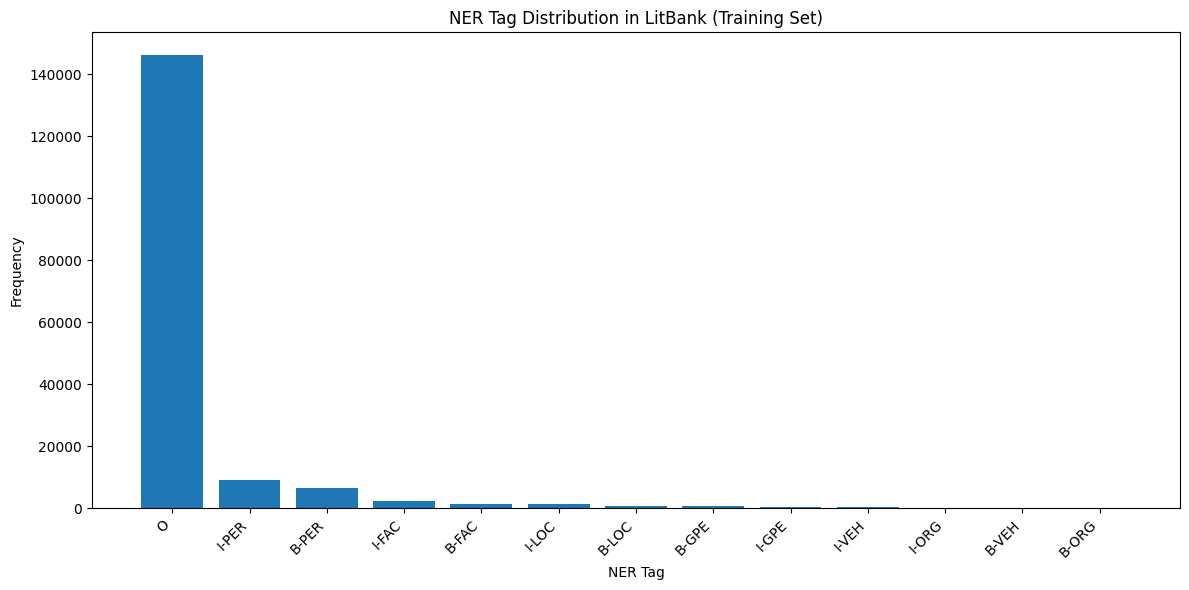


Entity Tags Only (excluding 'O'):


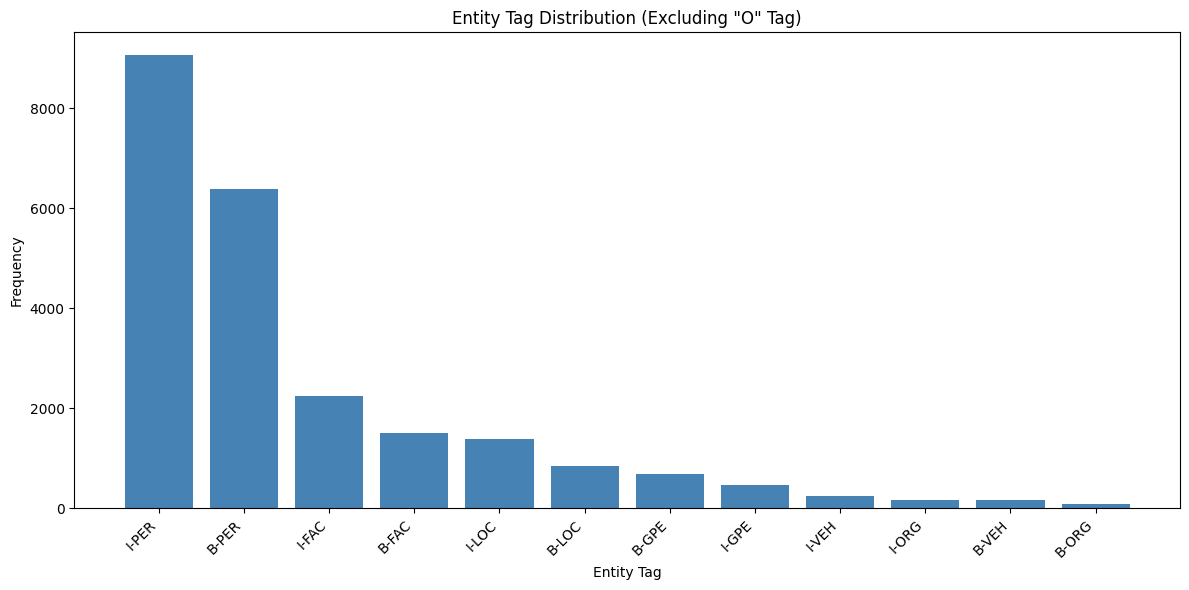

In [6]:
# Count all NER tags in the training data
def get_tag_distribution(flattened_data):
    """Count how many times each NER tag appears."""
    all_tags = []  # Collect all tags
    
    # Loop through each sentence
    for example in flattened_data:
        # Add all tags from this sentence to our list
        all_tags.extend(example['ner_tags'])
    
    # Count occurrences of each tag
    return Counter(all_tags)

# Get tag distribution from training data
tag_dist = get_tag_distribution(train_data)

# Print the distribution
print("\nNER Tag Distribution:")
for tag, count in sorted(tag_dist.items()):
    # Calculate percentage
    percentage = (count / sum(tag_dist.values())) * 100
    print(f"{tag:15s}: {count:6d} occurrences ({percentage:5.2f}%)")

# Visualize the distribution
plt.figure(figsize=(12, 6))
# Sort tags by count for better visualization
sorted_tags = sorted(tag_dist.items(), key=lambda x: x[1], reverse=True)
tags, counts = zip(*sorted_tags)
# Create bar plot
plt.bar(range(len(tags)), counts)
plt.xticks(range(len(tags)), tags, rotation=45, ha='right')
plt.xlabel('NER Tag')
plt.ylabel('Frequency')
plt.title('NER Tag Distribution in LitBank (Training Set)')
plt.tight_layout()
plt.show()

# Also show distribution without 'O' tag for better visibility of entities
entity_tags = {tag: count for tag, count in tag_dist.items() if tag != 'O'}
if entity_tags:
    print("\nEntity Tags Only (excluding 'O'):")
    plt.figure(figsize=(12, 6))
    sorted_entity_tags = sorted(entity_tags.items(), key=lambda x: x[1], reverse=True)
    tags, counts = zip(*sorted_entity_tags)
    plt.bar(range(len(tags)), counts, color='steelblue')
    plt.xticks(range(len(tags)), tags, rotation=45, ha='right')
    plt.xlabel('Entity Tag')
    plt.ylabel('Frequency')
    plt.title('Entity Tag Distribution (Excluding "O" Tag)')
    plt.tight_layout()
    plt.show()

**Create Tag Mappings**

Neural networks work with numbers, not text. The following cell creates two dictionaries to "translate" the tags to numbers and back again:
- `tag2idx`: Tag names (like "B-PER") → numbers (like 0, 1, 2...)
- `idx2tags`: Numbers → tag names (for interpreting predictions)

In [7]:
# Extract all unique tags from the training data
all_tags = set()  # create a set to get unique values only
for example in train_data:
    # Add all tags from this sentence to the set
    all_tags.update(example['ner_tags'])

# IMPORTANT FIX: Don't put 'O' at index 0!
# We need a special padding index that's different from 'O'
# Sort alphabetically, 'O' will get a valid index (not 0)
tag_names = sorted(all_tags)

# Create mapping: tag name → number (for converting labels to model input)
tag2idx = {tag: idx for idx, tag in enumerate(tag_names)}

# Create reverse mapping: number → tag name (for converting predictions to readable tags)
idx2tag = {idx: tag for idx, tag in enumerate(tag_names)}

# Define a special padding index that doesn't conflict with any tag
# We'll use -100, which is a common choice for ignored indices in PyTorch
PAD_TAG_IDX = -100

# Print the mappings
print("Tag to Index Mapping:")
for tag, idx in sorted(tag2idx.items(), key=lambda x: x[1]):
    print(f"  {tag:15s} → {idx}")

print(f"\nPadding tag index: {PAD_TAG_IDX} (will be ignored in loss calculation)")
print(f"Total unique tags: {len(tag_names)}")
print(f"\n⚠️  IMPORTANT: 'O' is now at index {tag2idx['O']}, NOT 0!")
print(f"   This allows the model to learn to predict 'O' tags correctly.")

Tag to Index Mapping:
  B-FAC           → 0
  B-GPE           → 1
  B-LOC           → 2
  B-ORG           → 3
  B-PER           → 4
  B-VEH           → 5
  I-FAC           → 6
  I-GPE           → 7
  I-LOC           → 8
  I-ORG           → 9
  I-PER           → 10
  I-VEH           → 11
  O               → 12

Padding tag index: -100 (will be ignored in loss calculation)
Total unique tags: 13

⚠️  IMPORTANT: 'O' is now at index 12, NOT 0!
   This allows the model to learn to predict 'O' tags correctly.


## 6. Analyze Sentence Lengths and Build Vocabulary

Understanding sentence length distribution helps us choose the right maximum sequence length (`MAX_LEN`) for the model (needs inputs of consistent, predictable size).  
The hyperparameter `MAX_LEN` will determine how much shorter sentences will be padded or where longer sentences are truncated.

Sentence Length Statistics:
  Mean:   25.09 tokens
  Median: 20 tokens
  Std:    20.49 tokens
  Min:    1 tokens
  Max:    307 tokens

Percentiles:
  50th percentile: 20 tokens
  75th percentile: 33 tokens
  90th percentile: 50 tokens
  95th percentile: 62 tokens
  99th percentile: 97 tokens


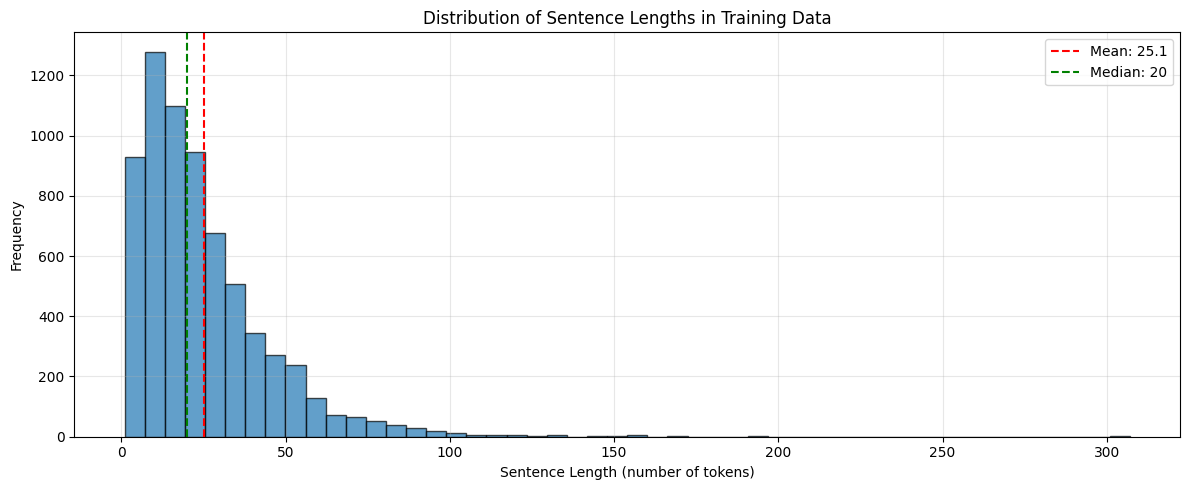


Recommended MAX_LEN: 62 (covers 95% of sentences)

Total unique words (before filtering): 14735
Vocabulary size (min_freq=2): 7265
Words filtered out: 7472

Sample vocabulary words: ['chapter', '1', 'call', 'me', '.', 'some', 'years', 'ago', '--', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in']

Special tokens:
  <PAD> index: 0
  <UNK> index: 1


In [8]:
# Calculate length of each sentence (number of tokens)
sentence_lengths = [len(example['tokens']) for example in train_data]

# Calculate statistics
print(f"Sentence Length Statistics:")
print(f"  Mean:   {np.mean(sentence_lengths):.2f} tokens")
print(f"  Median: {np.median(sentence_lengths):.0f} tokens")
print(f"  Std:    {np.std(sentence_lengths):.2f} tokens")
print(f"  Min:    {np.min(sentence_lengths)} tokens")
print(f"  Max:    {np.max(sentence_lengths)} tokens")

# Calculate percentiles to help choose max_len
percentiles = [50, 75, 90, 95, 99]
print(f"\nPercentiles:")
for p in percentiles:
    value = np.percentile(sentence_lengths, p)
    print(f"  {p}th percentile: {value:.0f} tokens")

# Visualize the distribution
plt.figure(figsize=(12, 5))
plt.hist(sentence_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(sentence_lengths), color='red', linestyle='--', 
            label=f'Mean: {np.mean(sentence_lengths):.1f}')
plt.axvline(np.median(sentence_lengths), color='green', linestyle='--', 
            label=f'Median: {np.median(sentence_lengths):.0f}')
plt.xlabel('Sentence Length (number of tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths in Training Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Suggest a good max_len value
recommended_max_len = int(np.percentile(sentence_lengths, 95))
print(f"\nRecommended MAX_LEN: {recommended_max_len} (covers 95% of sentences)")

# Build vocabulary from training data
def build_vocab(flattened_data, min_freq=2):
    """
    Build vocabulary from training data.
    
    Args:
        flattened_data: List of sentence dicts with 'tokens'
        min_freq: Minimum frequency for a word to be included (default=2)
                  Words appearing less than this become <UNK> (unknown)
    
    Returns:
        word2idx: Dictionary mapping words to indices
        vocab: List of all words in vocabulary
    """
    # Count how many times each word appears
    word_freq = Counter()
    for example in flattened_data:
        # Convert to lowercase for case-insensitive vocabulary
        word_freq.update([token.lower() for token in example['tokens']])
    
    # Build vocabulary: special tokens first, then frequent words
    # <PAD>: Padding token (index 0) - used to make all sequences same length
    # <UNK>: Unknown token (index 1) - used for words not in vocabulary
    vocab = ['<PAD>', '<UNK>']
    
    # Add words that appear at least min_freq times
    vocab.extend([word for word, freq in word_freq.items() if freq >= min_freq])
    
    # Create mapping: word → index
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    
    # Print statistics
    print(f"\nTotal unique words (before filtering): {len(word_freq)}")
    print(f"Vocabulary size (min_freq={min_freq}): {len(vocab)}")
    print(f"Words filtered out: {len(word_freq) - (len(vocab) - 2)}")
    
    return word2idx, vocab

# Build vocabulary from training data
word2idx, vocab = build_vocab(train_data, min_freq=2)

# Show some example words from vocabulary
print(f"\nSample vocabulary words: {vocab[2:22]}")  # Skip <PAD> and <UNK>
print(f"\nSpecial tokens:")
print(f"  <PAD> index: {word2idx['<PAD>']}")
print(f"  <UNK> index: {word2idx['<UNK>']}")

## 7. Load Pre-trained GloVe Embeddings

GloVe (Global Vectors for Word Representation) are pre-trained word embeddings that capture semantic relationships between words. We'll use the 100-dimensional GloVe embeddings trained on Common Crawl.

**Why GloVe?**
- Pre-trained on massive text corpora (840B tokens)
- Captures semantic and syntactic relationships
- May help with rare words and literary language

**Note**: You need to download GloVe embeddings first. Download from: https://nlp.stanford.edu/projects/glove/

In [9]:
def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    """
    Load pre-trained GloVe embeddings and create embedding matrix for our vocabulary.
    
    Args:
        glove_path: Path to GloVe file (e.g., 'glove.6B.100d.txt')
        word2idx: Dictionary mapping words to indices in our vocabulary
        embedding_dim: Dimension of GloVe vectors (50, 100, 200, or 300)
    
    Returns:
        embedding_matrix: NumPy array of shape (vocab_size, embedding_dim)
                         Each row i contains the embedding for word at index i
    """
    print(f"Loading GloVe embeddings from: {glove_path}")
    print(f"This may take a few minutes...\n")
    
    # Initialize embedding matrix with random values (for words not in GloVe)
    # We use a small random initialization that will be updated during training
    vocab_size = len(word2idx)
    embedding_matrix = np.random.uniform(-0.25, 0.25, (vocab_size, embedding_dim))
    
    # Set padding token to zeros (index 0)
    embedding_matrix[0] = np.zeros(embedding_dim)
    
    # Track statistics
    found_words = 0
    
    # Read GloVe file and populate embedding matrix
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            # Each line is: word vec[0] vec[1] ... vec[embedding_dim-1]
            values = line.split()
            word = values[0]
            
            # Check if this word is in our vocabulary
            if word in word2idx:
                # Extract embedding vector (convert strings to floats)
                vector = np.array(values[1:], dtype='float32')
                
                # Store in our embedding matrix at the correct index
                idx = word2idx[word]
                embedding_matrix[idx] = vector
                found_words += 1
    
    # Print coverage statistics
    coverage = (found_words / vocab_size) * 100
    print(f"\nGloVe Coverage:")
    print(f"  Words in vocabulary: {vocab_size:,}")
    print(f"  Words found in GloVe: {found_words:,}")
    print(f"  Coverage: {coverage:.2f}%")
    print(f"  Words using random initialization: {vocab_size - found_words:,}")
    
    return embedding_matrix

# Configuration: Set this to your GloVe file path
# You can download GloVe from: https://nlp.stanford.edu/projects/glove/
# For this project, we use glove.6B.100d.txt (100-dimensional vectors)
GLOVE_PATH = "../data/glove.6B.100d.txt"  # Adjust this path as needed
EMBEDDING_DIM = 100  # Must match the GloVe file (50, 100, 200, or 300)

# Check if GloVe file exists
if os.path.exists(GLOVE_PATH):
    # Load GloVe embeddings for our vocabulary
    glove_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, EMBEDDING_DIM)
    print(f"\nGloVe embedding matrix shape: {glove_embeddings.shape}")
    print(f"Expected shape: ({len(word2idx)}, {EMBEDDING_DIM})")
else:
    print(f"\n⚠️  GloVe file not found at: {GLOVE_PATH}")
    print("\nPlease download GloVe embeddings:")
    print("1. Visit: https://nlp.stanford.edu/projects/glove/")
    print("2. Download: glove.6B.zip (822 MB)")
    print("3. Extract glove.6B.100d.txt to ../data/")
    print("4. Update GLOVE_PATH variable above if using a different location")
    print("\nAlternatively, you can train with random embeddings only.")
    glove_embeddings = None

Loading GloVe embeddings from: ../data/glove.6B.100d.txt
This may take a few minutes...



Loading GloVe: 0it [00:00, ?it/s]


GloVe Coverage:
  Words in vocabulary: 7,265
  Words found in GloVe: 7,097
  Coverage: 97.69%
  Words using random initialization: 168

GloVe embedding matrix shape: (7265, 100)
Expected shape: (7265, 100)


## 8. Create PyTorch Dataset Class

This class handles:
- Converting words to numbers
- Converting tags to numbers
- Padding sequences to the same length
- Creating attention masks (to ignore padding)

In [10]:
class NERDataset(Dataset):
    """
    Custom PyTorch Dataset for Named Entity Recognition.
    
    Converts tokens and tags to numerical format and handles padding.
    """
    
    def __init__(self, data, word2idx, tag2idx, max_len=128, pad_tag_idx=-100):
        """
        Args:
            data: List of dicts with 'tokens' and 'ner_tags'
            word2idx: Dictionary mapping words to indices
            tag2idx: Dictionary mapping tags to indices
            max_len: Maximum sequence length (longer sequences are truncated)
            pad_tag_idx: Special index for padding tags (default=-100, ignored in loss)
        """
        self.data = data  # Store the data
        self.word2idx = word2idx  # Store word mappings
        self.tag2idx = tag2idx  # Store tag mappings
        self.max_len = max_len  # Store max length
        self.pad_tag_idx = pad_tag_idx  # Store padding tag index
    
    def __len__(self):
        """Return the number of examples in the dataset."""
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Get a single example from the dataset.
        
        Returns:
            Dictionary with:
                - input_ids: Token indices (padded to max_len)
                - labels: Tag indices (padded to max_len)
                - attention_mask: 1 for real tokens, 0 for padding
        """
        # Get the example at this index
        example = self.data[idx]
        tokens = example['tokens']  # List of words
        tags = example['ner_tags']  # List of NER tags
        
        # Convert tokens to indices
        # Use <UNK> index for words not in vocabulary
        token_ids = [
            self.word2idx.get(token.lower(), self.word2idx['<UNK>']) 
            for token in tokens
        ]
        
        # Convert tags to indices
        tag_ids = [self.tag2idx[tag] for tag in tags]
        
        # Truncate or pad to max_len
        if len(token_ids) > self.max_len:
            # Sequence too long: truncate
            token_ids = token_ids[:self.max_len]
            tag_ids = tag_ids[:self.max_len]
        else:
            # Sequence too short: pad
            padding_len = self.max_len - len(token_ids)
            token_ids = token_ids + [self.word2idx['<PAD>']] * padding_len
            # IMPORTANT FIX: Use special padding index (e.g., -100) instead of 0
            # This ensures 'O' tags are not confused with padding
            tag_ids = tag_ids + [self.pad_tag_idx] * padding_len
        
        # Create attention mask: 1 for real tokens, 0 for padding
        # The model will ignore positions with 0 in the mask
        attention_mask = [
            1 if tid != self.word2idx['<PAD>'] else 0 
            for tid in token_ids
        ]
        
        # Return as PyTorch tensors
        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),  # Token indices
            'labels': torch.tensor(tag_ids, dtype=torch.long),  # Tag indices
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long)  # Mask
        }

# =============================================================================
# HYPERPARAMETERS: You can easily adjust these values
# =============================================================================
MAX_LEN = 128        # Maximum sequence length (adjust based on sentence length analysis)
BATCH_SIZE = 16      # Number of examples per batch (increase if you have more memory)

# Create dataset objects for train, validation, and test splits
# Use PAD_TAG_IDX for padding (defined in previous cell)
train_dataset = NERDataset(train_data, word2idx, tag2idx, MAX_LEN, PAD_TAG_IDX)
val_dataset = NERDataset(val_data, word2idx, tag2idx, MAX_LEN, PAD_TAG_IDX)
test_dataset = NERDataset(test_data, word2idx, tag2idx, MAX_LEN, PAD_TAG_IDX)

# Create data loaders (handle batching and shuffling)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True  # Shuffle training data each epoch
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False  # Don't shuffle validation data
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False  # Don't shuffle test data
)

# Print dataset sizes
print(f"Dataset sizes:")
print(f"  Training:   {len(train_dataset):4d} sentences, {len(train_loader):3d} batches")
print(f"  Validation: {len(val_dataset):4d} sentences, {len(val_loader):3d} batches")
print(f"  Test:       {len(test_dataset):4d} sentences, {len(test_loader):3d} batches")

# Test: Get one batch and show its shape
sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  input_ids:      {sample_batch['input_ids'].shape}  (batch_size, max_len)")
print(f"  labels:         {sample_batch['labels'].shape}  (batch_size, max_len)")
print(f"  attention_mask: {sample_batch['attention_mask'].shape}  (batch_size, max_len)")

print(f"\n✓ Dataset now uses PAD_TAG_IDX={PAD_TAG_IDX} for padding tags")
print(f"  This prevents 'O' tags from being ignored during training!")

Dataset sizes:
  Training:   6755 sentences, 423 batches
  Validation:  927 sentences,  58 batches
  Test:        880 sentences,  55 batches

Sample batch shapes:
  input_ids:      torch.Size([16, 128])  (batch_size, max_len)
  labels:         torch.Size([16, 128])  (batch_size, max_len)
  attention_mask: torch.Size([16, 128])  (batch_size, max_len)

✓ Dataset now uses PAD_TAG_IDX=-100 for padding tags
  This prevents 'O' tags from being ignored during training!


## 9. Define BiLSTM Model Architecture

This model is designed to be **highly configurable** for easy experimentation:

**Architecture**:
1. **Embedding layer**: Converts word indices to dense vectors
   - Can use random initialization or pre-trained GloVe
   - Can be frozen or fine-tuned during training
2. **BiLSTM layer**: Processes sequence in both directions (forward and backward)
   - Number of layers is configurable
   - Hidden dimension is configurable
3. **Dropout**: Regularization to prevent overfitting
4. **Classification layer**: Predicts NER tag for each token

**Key Parameters for Experimentation**:
- `embedding_dim`: Size of word embeddings (e.g., 50, 100, 200, 300)
- `hidden_dim`: Size of LSTM hidden state (e.g., 64, 128, 256)
- `num_layers`: Number of stacked LSTM layers (e.g., 1, 2, 3)
- `dropout`: Dropout probability (e.g., 0.1, 0.3, 0.5)
- `pretrained_embeddings`: Optional pre-trained embedding matrix
- `freeze_embeddings`: Whether to freeze embeddings during training

In [11]:
class BiLSTMTagger(nn.Module):
    """
    Bidirectional LSTM model for sequence labeling (NER).
    
    Architecture:
        Input (token ids) → Embedding → BiLSTM → Dropout → Linear → Output (tag logits)
    
    This model is designed for easy experimentation with different configurations.
    """
    
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 num_tags,
                 num_layers=2, 
                 dropout=0.3,
                 pretrained_embeddings=None,
                 freeze_embeddings=False):
        """
        Initialize the BiLSTM model.
        
        Args:
            vocab_size: Size of word vocabulary
            embedding_dim: Dimension of word embeddings (e.g., 100 for GloVe 100d)
            hidden_dim: Dimension of LSTM hidden state (controls model capacity)
            num_tags: Number of NER tags (output classes)
            num_layers: Number of stacked LSTM layers (default=2)
                       More layers can capture more complex patterns but may overfit
            dropout: Dropout probability for regularization (default=0.3)
                    Higher values prevent overfitting but may underfit
            pretrained_embeddings: Optional pre-trained embedding matrix (NumPy array)
                                  Shape: (vocab_size, embedding_dim)
                                  If None, embeddings are randomly initialized
            freeze_embeddings: If True, don't update embeddings during training
                              Useful for preserving pre-trained semantic relationships
        """
        super(BiLSTMTagger, self).__init__()
        
        # Store configuration for later reference
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        # =============================================================================
        # EMBEDDING LAYER: Converts word indices to dense vectors
        # =============================================================================
        # padding_idx=0 means the padding token (index 0) has zero embedding
        self.embedding = nn.Embedding(
            vocab_size,      # Number of words in vocabulary
            embedding_dim,   # Size of embedding vector for each word
            padding_idx=0    # Padding token index (will have zero vector)
        )
        
        # If pre-trained embeddings are provided, load them
        if pretrained_embeddings is not None:
            print("  Loading pre-trained embeddings...")
            # Convert NumPy array to PyTorch tensor
            self.embedding.weight = nn.Parameter(
                torch.tensor(pretrained_embeddings, dtype=torch.float32)
            )
            # Optionally freeze embeddings (don't update during training)
            if freeze_embeddings:
                print("  Freezing embedding weights (will not be updated during training)")
                self.embedding.weight.requires_grad = False
            else:
                print("  Embeddings will be fine-tuned during training")
        else:
            print("  Using randomly initialized embeddings")
        
        # =============================================================================
        # DROPOUT LAYER: Regularization to prevent overfitting
        # =============================================================================
        # Randomly sets a fraction of inputs to 0 during training
        # This prevents the model from relying too much on any single feature
        self.dropout_layer = nn.Dropout(dropout)
        
        # =============================================================================
        # BiLSTM LAYER: Processes sequence in both directions
        # =============================================================================
        # LSTM (Long Short-Term Memory) handles long-range dependencies better than simple RNN
        # Bidirectional means it processes the sequence both forward and backward
        # This gives the model context from both past and future tokens
        self.lstm = nn.LSTM(
            embedding_dim,           # Input size (size of word embeddings)
            hidden_dim,              # Hidden state size (controls model capacity)
            num_layers=num_layers,   # Stack multiple LSTM layers for more expressiveness
            bidirectional=True,      # Process sequence in both directions
            batch_first=True,        # Input shape: (batch, seq_len, features)
            dropout=dropout if num_layers > 1 else 0  # Dropout between LSTM layers
        )
        
        # =============================================================================
        # OUTPUT LAYER: Maps BiLSTM output to tag scores
        # =============================================================================
        # BiLSTM outputs are concatenated (forward + backward), so output dim is 2 * hidden_dim
        # This layer produces a score for each possible NER tag for each token
        self.fc = nn.Linear(
            hidden_dim * 2,  # Input: BiLSTM output (forward + backward)
            num_tags         # Output: Score for each NER tag
        )
    
    def forward(self, input_ids, attention_mask=None):
        """
        Forward pass through the model.
        
        Args:
            input_ids: Token indices, shape (batch_size, seq_len)
            attention_mask: Mask for padding, shape (batch_size, seq_len)
                           1 for real tokens, 0 for padding
        
        Returns:
            logits: Tag scores for each token, shape (batch_size, seq_len, num_tags)
                   Higher score = more confident prediction for that tag
        """
        # Step 1: Convert token indices to embeddings
        # Shape: (batch_size, seq_len) → (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(input_ids)
        
        # Apply dropout to embeddings for regularization
        embedded = self.dropout_layer(embedded)
        
        # Step 2: Process sequence with BiLSTM
        # lstm_out contains the output from both forward and backward passes
        # Shape: (batch_size, seq_len, embedding_dim) → (batch_size, seq_len, hidden_dim * 2)
        lstm_out, _ = self.lstm(embedded)
        
        # Apply dropout to LSTM output
        lstm_out = self.dropout_layer(lstm_out)
        
        # Step 3: Predict tag for each token
        # Maps LSTM output to tag scores
        # Shape: (batch_size, seq_len, hidden_dim * 2) → (batch_size, seq_len, num_tags)
        logits = self.fc(lstm_out)
        
        return logits
    
    def get_config(self):
        """
        Return model configuration for logging and reproducibility.
        """
        return {
            'vocab_size': self.vocab_size,
            'embedding_dim': self.embedding_dim,
            'hidden_dim': self.hidden_dim,
            'num_layers': self.num_layers,
            'dropout': self.dropout,
            'bidirectional': True  # Always True for BiLSTM
        }

print("BiLSTM model class defined successfully!")
print("\nYou can easily experiment with different architectures by changing:")
print("  - embedding_dim: Size of word vectors (50, 100, 200, 300)")
print("  - hidden_dim: LSTM hidden state size (64, 128, 256, 512)")
print("  - num_layers: Number of LSTM layers (1, 2, 3, 4)")
print("  - dropout: Regularization strength (0.1, 0.3, 0.5)")
print("  - pretrained_embeddings: Use GloVe or random initialization")
print("  - freeze_embeddings: Freeze or fine-tune pre-trained embeddings")

BiLSTM model class defined successfully!

You can easily experiment with different architectures by changing:
  - embedding_dim: Size of word vectors (50, 100, 200, 300)
  - hidden_dim: LSTM hidden state size (64, 128, 256, 512)
  - num_layers: Number of LSTM layers (1, 2, 3, 4)
  - dropout: Regularization strength (0.1, 0.3, 0.5)
  - pretrained_embeddings: Use GloVe or random initialization
  - freeze_embeddings: Freeze or fine-tune pre-trained embeddings


## 10. Initialize Models with Different Embeddings

We'll create two BiLSTM models with identical architecture but different embedding strategies:

1. **BiLSTM with Random Embeddings**: 
   - Embeddings initialized randomly
   - Learned from scratch during training
   - No prior knowledge of word meanings

2. **BiLSTM with GloVe Embeddings**:
   - Embeddings initialized with pre-trained GloVe vectors
   - Fine-tuned during training (not frozen)
   - Benefits from semantic knowledge learned on massive text corpora

**Note**: All other hyperparameters are kept identical for fair comparison.

## 11. Training and Evaluation Functions

These functions handle:
- **Training loop**: Forward pass, loss calculation, backward pass, weight updates
- **Evaluation**: Calculate metrics (F1, precision, recall) using seqeval

**Key Features**:
- Progress bars for monitoring training
- Gradient clipping to prevent exploding gradients
- Proper handling of padding tokens (ignored in loss calculation)
- Per-entity metrics using seqeval (handles multi-token entities correctly)

In [12]:
# =============================================================================
# MODEL HYPERPARAMETERS: Easy to adjust for experimentation
# =============================================================================
EMBEDDING_DIM = 100   # Dimension of word embeddings (must match GloVe if using pre-trained)
HIDDEN_DIM = 128      # Size of LSTM hidden state (controls model capacity)
NUM_LAYERS = 2        # Number of stacked LSTM layers
DROPOUT = 0.3         # Dropout probability (0.0 = no dropout, 0.5 = aggressive)
NUM_TAGS = len(tag_names)  # Number of output classes (NER tags)
VOCAB_SIZE = len(vocab)    # Size of vocabulary

# Whether to freeze GloVe embeddings or fine-tune them
FREEZE_GLOVE = False  # Set to True to prevent updating GloVe embeddings during training

print("="*80)
print("INITIALIZING MODELS")
print("="*80)
print(f"\nModel Configuration:")
print(f"  Vocabulary size:     {VOCAB_SIZE:,}")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Hidden dimension:    {HIDDEN_DIM}")
print(f"  Number of layers:    {NUM_LAYERS}")
print(f"  Dropout:             {DROPOUT}")
print(f"  Number of tags:      {NUM_TAGS}")
print(f"  Freeze GloVe:        {FREEZE_GLOVE}")

# Dictionary to store our models
models = {}

# =============================================================================
# MODEL 1: BiLSTM with Random Embeddings (Baseline)
# =============================================================================
print("\n" + "-"*80)
print("Model 1: BiLSTM with Random Embeddings")
print("-"*80)
models['BiLSTM_Random'] = BiLSTMTagger(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_tags=NUM_TAGS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pretrained_embeddings=None,  # No pre-trained embeddings
    freeze_embeddings=False       # Not applicable for random init
)

# =============================================================================
# MODEL 2: BiLSTM with GloVe Embeddings
# =============================================================================
print("\n" + "-"*80)
print("Model 2: BiLSTM with GloVe Embeddings")
print("-"*80)
if glove_embeddings is not None:
    models['BiLSTM_GloVe'] = BiLSTMTagger(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        num_tags=NUM_TAGS,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        pretrained_embeddings=glove_embeddings,  # Use GloVe embeddings
        freeze_embeddings=FREEZE_GLOVE           # Fine-tune or freeze
    )
else:
    print("  ⚠️  GloVe embeddings not loaded. Skipping this model.")
    print("  Please load GloVe embeddings in the previous cell to train this model.")

# =============================================================================
# Print Model Statistics
# =============================================================================
print("\n" + "="*80)
print("MODEL STATISTICS")
print("="*80)

for model_name, model in models.items():
    # Count total parameters
    total_params = sum(p.numel() for p in model.parameters())
    # Count trainable parameters (may be less if embeddings are frozen)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n{model_name}:")
    print(f"  Total parameters:     {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    
    # Show if any parameters are frozen
    if total_params != trainable_params:
        frozen_params = total_params - trainable_params
        print(f"  Frozen parameters:    {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")

print("\n" + "="*80)
print(f"Successfully initialized {len(models)} model(s)!")
print("="*80)

INITIALIZING MODELS

Model Configuration:
  Vocabulary size:     7,265
  Embedding dimension: 100
  Hidden dimension:    128
  Number of layers:    2
  Dropout:             0.3
  Number of tags:      13
  Freeze GloVe:        False

--------------------------------------------------------------------------------
Model 1: BiLSTM with Random Embeddings
--------------------------------------------------------------------------------
  Using randomly initialized embeddings

--------------------------------------------------------------------------------
Model 2: BiLSTM with GloVe Embeddings
--------------------------------------------------------------------------------
  Loading pre-trained embeddings...
  Embeddings will be fine-tuned during training

MODEL STATISTICS

BiLSTM_Random:
  Total parameters:     1,360,625
  Trainable parameters: 1,360,625

BiLSTM_GloVe:
  Total parameters:     1,360,625
  Trainable parameters: 1,360,625

Successfully initialized 2 model(s)!


## 12. Training Loop

Train both models (Random and GloVe embeddings) and track their progress.

**Training Configuration** (easily adjustable):
- Number of epochs
- Learning rate
- Optimizer settings
- Model checkpoint saving

Each model is trained independently and the best version (based on validation F1) is saved.

In [13]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    
    Args:
        model: The BiLSTM model to train
        dataloader: DataLoader for training data
        optimizer: Optimizer (e.g., Adam)
        criterion: Loss function (e.g., CrossEntropyLoss)
        device: torch device (CPU or GPU)
    
    Returns:
        float: Average loss for this epoch
    """
    # Set model to training mode
    # This enables dropout and other training-specific behaviors
    model.train()
    
    total_loss = 0  # Accumulate loss over all batches
    
    # Loop through batches with progress bar
    for batch in tqdm(dataloader, desc='Training', leave=False):
        # Move batch tensors to device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)        # Token indices
        labels = batch['labels'].to(device)              # True NER tags
        attention_mask = batch['attention_mask'].to(device)  # Padding mask
        
        # Reset gradients from previous iteration
        # PyTorch accumulates gradients, so we need to zero them out
        optimizer.zero_grad()
        
        # Forward pass: Get predictions from model
        # logits shape: (batch_size, seq_len, num_tags)
        logits = model(input_ids, attention_mask)
        
        # Reshape tensors for loss calculation
        # CrossEntropyLoss expects:
        #   - predictions: (N, num_classes) where N = batch_size * seq_len
        #   - targets: (N,)
        logits_flat = logits.view(-1, logits.shape[-1])  # (batch_size * seq_len, num_tags)
        labels_flat = labels.view(-1)                    # (batch_size * seq_len,)
        
        # Calculate loss (how wrong are the predictions?)
        # Padding tokens (label=0) are automatically ignored due to ignore_index=0
        loss = criterion(logits_flat, labels_flat)
        
        # Backward pass: Calculate gradients
        # This computes the gradient of loss with respect to each parameter
        loss.backward()
        
        # Gradient clipping: Prevent exploding gradients
        # If gradients are too large, they can cause training instability
        # We clip them to a maximum norm of 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update model parameters using gradients
        optimizer.step()
        
        # Accumulate loss for averaging
        total_loss += loss.item()
    
    # Return average loss over all batches
    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device, idx2tag):
    """
    Evaluate the model on validation/test data.
    
    Args:
        model: The BiLSTM model to evaluate
        dataloader: DataLoader for validation/test data
        criterion: Loss function
        device: torch device (CPU or GPU)
        idx2tag: Dictionary mapping tag indices to tag names
    
    Returns:
        tuple: (avg_loss, f1, precision, recall, predictions, true_labels)
            - avg_loss: Average loss over all batches
            - f1: F1 score (harmonic mean of precision and recall)
            - precision: Precision score
            - recall: Recall score
            - predictions: List of predicted tag sequences (for analysis)
            - true_labels: List of true tag sequences (for analysis)
    """
    # Set model to evaluation mode
    # This disables dropout and other training-specific behaviors
    model.eval()
    
    total_loss = 0      # Accumulate loss
    predictions = []    # Store all predictions
    true_labels = []    # Store all true labels
    
    # Disable gradient calculation for evaluation (saves memory and computation)
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating', leave=False):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Forward pass: Get predictions
            logits = model(input_ids, attention_mask)
            
            # Calculate loss
            logits_flat = logits.view(-1, logits.shape[-1])
            labels_flat = labels.view(-1)
            loss = criterion(logits_flat, labels_flat)
            total_loss += loss.item()
            
            # Get predicted tags: Choose tag with highest score for each token
            # argmax returns the index of the maximum value
            preds = torch.argmax(logits, dim=-1)  # Shape: (batch_size, seq_len)
            
            # Convert predictions and labels to tag names
            # Only include non-padded tokens (attention_mask == 1)
            for i in range(len(preds)):
                pred_tags = []  # Predicted tags for this sequence
                true_tags = []  # True tags for this sequence
                
                # Loop through each token in the sequence
                for j in range(len(preds[i])):
                    # Only process real tokens (not padding)
                    if attention_mask[i][j] == 1:
                        # Convert index to tag name using idx2tag mapping
                        pred_idx = preds[i][j].item()
                        true_idx = labels[i][j].item()
                        
                        pred_tags.append(idx2tag.get(pred_idx, 'O'))
                        true_tags.append(idx2tag.get(true_idx, 'O'))
                
                # Only add non-empty sequences
                if pred_tags:
                    predictions.append(pred_tags)
                    true_labels.append(true_tags)
    
    # Calculate average loss
    avg_loss = total_loss / len(dataloader)
    
    # Calculate NER metrics using seqeval
    # seqeval properly handles multi-token entities (e.g., "B-PER I-PER")
    # It treats "B-PER I-PER" as a single entity, not two separate tokens
    f1 = f1_score(true_labels, predictions)           # F1 score
    precision = precision_score(true_labels, predictions)  # Precision
    recall = recall_score(true_labels, predictions)        # Recall
    
    return avg_loss, f1, precision, recall, predictions, true_labels


print("Training and evaluation functions defined successfully!")
print("\\nThese functions include:")
print("  ✓ Automatic handling of padding tokens")
print("  ✓ Gradient clipping for stable training")
print("  ✓ Progress bars for monitoring")
print("  ✓ Proper NER evaluation with seqeval")

Training and evaluation functions defined successfully!
\nThese functions include:
  ✓ Automatic handling of padding tokens
  ✓ Gradient clipping for stable training
  ✓ Progress bars for monitoring
  ✓ Proper NER evaluation with seqeval


## 13. Visualize Training Progress

Plot learning curves to see how models improved over epochs. This helps us understand:
- Whether models are converging
- If there's overfitting (train loss decreasing but val loss increasing)
- How quickly each model learns
- Comparative performance between random and GloVe embeddings

In [14]:
def train_model(model, train_loader, val_loader, model_name, 
                num_epochs=5, learning_rate=0.001):
    """
    Train a model for multiple epochs and save the best version.
    
    Args:
        model: The BiLSTM model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        model_name: Name for saving the model (e.g., "BiLSTM_Random")
        num_epochs: Number of training epochs (default=15)
        learning_rate: Learning rate for Adam optimizer (default=0.001)
    
    Returns:
        history: Dictionary with training metrics per epoch
        best_f1: Best F1 score achieved on validation set
    """
    # Move model to device (GPU or CPU)
    model = model.to(device)
    
    # Loss function: Cross Entropy Loss
    # IMPORTANT FIX: Use PAD_TAG_IDX (not 0) to ignore padding tokens
    # This allows the model to learn 'O' tags properly
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_IDX)
    
    # Optimizer: Adam (Adaptive Moment Estimation)
    # Adam automatically adjusts learning rate for each parameter
    # It's generally more robust than SGD and requires less tuning
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Track metrics over epochs for visualization
    history = {
        'train_loss': [],      # Training loss per epoch
        'val_loss': [],        # Validation loss per epoch
        'val_f1': [],          # Validation F1 score per epoch
        'val_precision': [],   # Validation precision per epoch
        'val_recall': []       # Validation recall per epoch
    }
    
    best_f1 = 0  # Track best F1 score for model saving
    
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}")
    print(f"Configuration:")
    print(f"  Device: {device}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Learning rate: {learning_rate}")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Ignore index: {PAD_TAG_IDX} (padding tags)")
    print(f"{'='*80}")
    
    # Train for num_epochs epochs
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 60)
        
        # =========================================================================
        # TRAINING PHASE
        # =========================================================================
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        history['train_loss'].append(train_loss)
        
        # =========================================================================
        # EVALUATION PHASE
        # =========================================================================
        val_loss, val_f1, val_precision, val_recall, _, _ = evaluate(
            model, val_loader, criterion, device, idx2tag
        )
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        
        # Print metrics for this epoch
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | F1: {val_f1:.4f} | "
              f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f}")
        
        # =========================================================================
        # MODEL CHECKPOINTING: Save best model based on F1 score
        # =========================================================================
        if val_f1 > best_f1:
            best_f1 = val_f1
            # Create results directory if it doesn't exist
            os.makedirs('../results', exist_ok=True)
            # Save model weights
            model_path = f'../results/{model_name}_best.pt'
            torch.save(model.state_dict(), model_path)
            print(f"  ✓ New best model saved! F1: {best_f1:.4f} → {model_path}")
    
    print(f"\n{'='*80}")
    print(f"Training completed for {model_name}!")
    print(f"Best validation F1: {best_f1:.4f}")
    print(f"{'='*80}\n")
    
    return history, best_f1


# =============================================================================
# TRAINING HYPERPARAMETERS: Easy to adjust for experimentation
# =============================================================================
NUM_EPOCHS = 5        # Number of epochs to train (more epochs = more training time)
LEARNING_RATE = 0.001  # Learning rate for Adam optimizer (typical range: 0.0001 to 0.01)

# Store results for all models
training_results = {}

print(f"\n{'='*80}")
print("STARTING TRAINING")
print(f"{'='*80}")
print(f"Training {len(models)} model(s):")
for model_name in models.keys():
    print(f"  - {model_name}")
print(f"\nThis may take a while depending on your hardware...")
print(f"{'='*80}\n")

# Train each model
for model_name, model in models.items():
    # Train the model and get training history
    history, best_f1 = train_model(
        model, 
        train_loader, 
        val_loader, 
        model_name, 
        NUM_EPOCHS, 
        LEARNING_RATE
    )
    
    # Store results for later comparison
    training_results[model_name] = {
        'history': history,     # Training metrics per epoch
        'best_f1': best_f1,     # Best F1 score on validation set
        'model': model          # The trained model
    }

print(f"\n{'='*80}")
print("ALL MODELS TRAINED SUCCESSFULLY!")
print(f"{'='*80}")
print("\nBest validation F1 scores:")
for model_name, results in training_results.items():
    print(f"  {model_name:20s}: {results['best_f1']:.4f}")
print(f"{'='*80}\n")


STARTING TRAINING
Training 2 model(s):
  - BiLSTM_Random
  - BiLSTM_GloVe

This may take a while depending on your hardware...


Training BiLSTM_Random
Configuration:
  Device: cpu
  Epochs: 5
  Learning rate: 0.001
  Batch size: 16
  Ignore index: -100 (padding tags)

Epoch 1/5
------------------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.5916
Val   Loss: 0.4310 | F1: 0.1238 | Precision: 0.4293 | Recall: 0.0723
  ✓ New best model saved! F1: 0.1238 → ../results/BiLSTM_Random_best.pt

Epoch 2/5
------------------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.4323
Val   Loss: 0.3514 | F1: 0.3720 | Precision: 0.5381 | Recall: 0.2843
  ✓ New best model saved! F1: 0.3720 → ../results/BiLSTM_Random_best.pt

Epoch 3/5
------------------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.3645
Val   Loss: 0.3179 | F1: 0.4386 | Precision: 0.5389 | Recall: 0.3698
  ✓ New best model saved! F1: 0.4386 → ../results/BiLSTM_Random_best.pt

Epoch 4/5
------------------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.3142
Val   Loss: 0.2995 | F1: 0.4750 | Precision: 0.5310 | Recall: 0.4297
  ✓ New best model saved! F1: 0.4750 → ../results/BiLSTM_Random_best.pt

Epoch 5/5
------------------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.2808
Val   Loss: 0.2911 | F1: 0.4998 | Precision: 0.5986 | Recall: 0.4289
  ✓ New best model saved! F1: 0.4998 → ../results/BiLSTM_Random_best.pt

Training completed for BiLSTM_Random!
Best validation F1: 0.4998


Training BiLSTM_GloVe
Configuration:
  Device: cpu
  Epochs: 5
  Learning rate: 0.001
  Batch size: 16
  Ignore index: -100 (padding tags)

Epoch 1/5
------------------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.4910
Val   Loss: 0.2996 | F1: 0.4794 | Precision: 0.5475 | Recall: 0.4265
  ✓ New best model saved! F1: 0.4794 → ../results/BiLSTM_GloVe_best.pt

Epoch 2/5
------------------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.3076
Val   Loss: 0.2660 | F1: 0.5402 | Precision: 0.6049 | Recall: 0.4881
  ✓ New best model saved! F1: 0.5402 → ../results/BiLSTM_GloVe_best.pt

Epoch 3/5
------------------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.2570
Val   Loss: 0.2443 | F1: 0.5557 | Precision: 0.5763 | Recall: 0.5366
  ✓ New best model saved! F1: 0.5557 → ../results/BiLSTM_GloVe_best.pt

Epoch 4/5
------------------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.2196
Val   Loss: 0.2310 | F1: 0.5991 | Precision: 0.6393 | Recall: 0.5637
  ✓ New best model saved! F1: 0.5991 → ../results/BiLSTM_GloVe_best.pt

Epoch 5/5
------------------------------------------------------------


Training:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1930
Val   Loss: 0.2334 | F1: 0.6215 | Precision: 0.6449 | Recall: 0.5998
  ✓ New best model saved! F1: 0.6215 → ../results/BiLSTM_GloVe_best.pt

Training completed for BiLSTM_GloVe!
Best validation F1: 0.6215


ALL MODELS TRAINED SUCCESSFULLY!

Best validation F1 scores:
  BiLSTM_Random       : 0.4998
  BiLSTM_GloVe        : 0.6215



Evaluating models on VALIDATION set for visualization...

Evaluating BiLSTM_Random on validation set...


Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

  F1: 0.4998, Precision: 0.5986, Recall: 0.4289

Evaluating BiLSTM_GloVe on validation set...


Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

  F1: 0.6215, Precision: 0.6449, Recall: 0.5998


COMPREHENSIVE VISUALIZATION CREATED

Saved to: ../results/comprehensive_comparison_validation.png



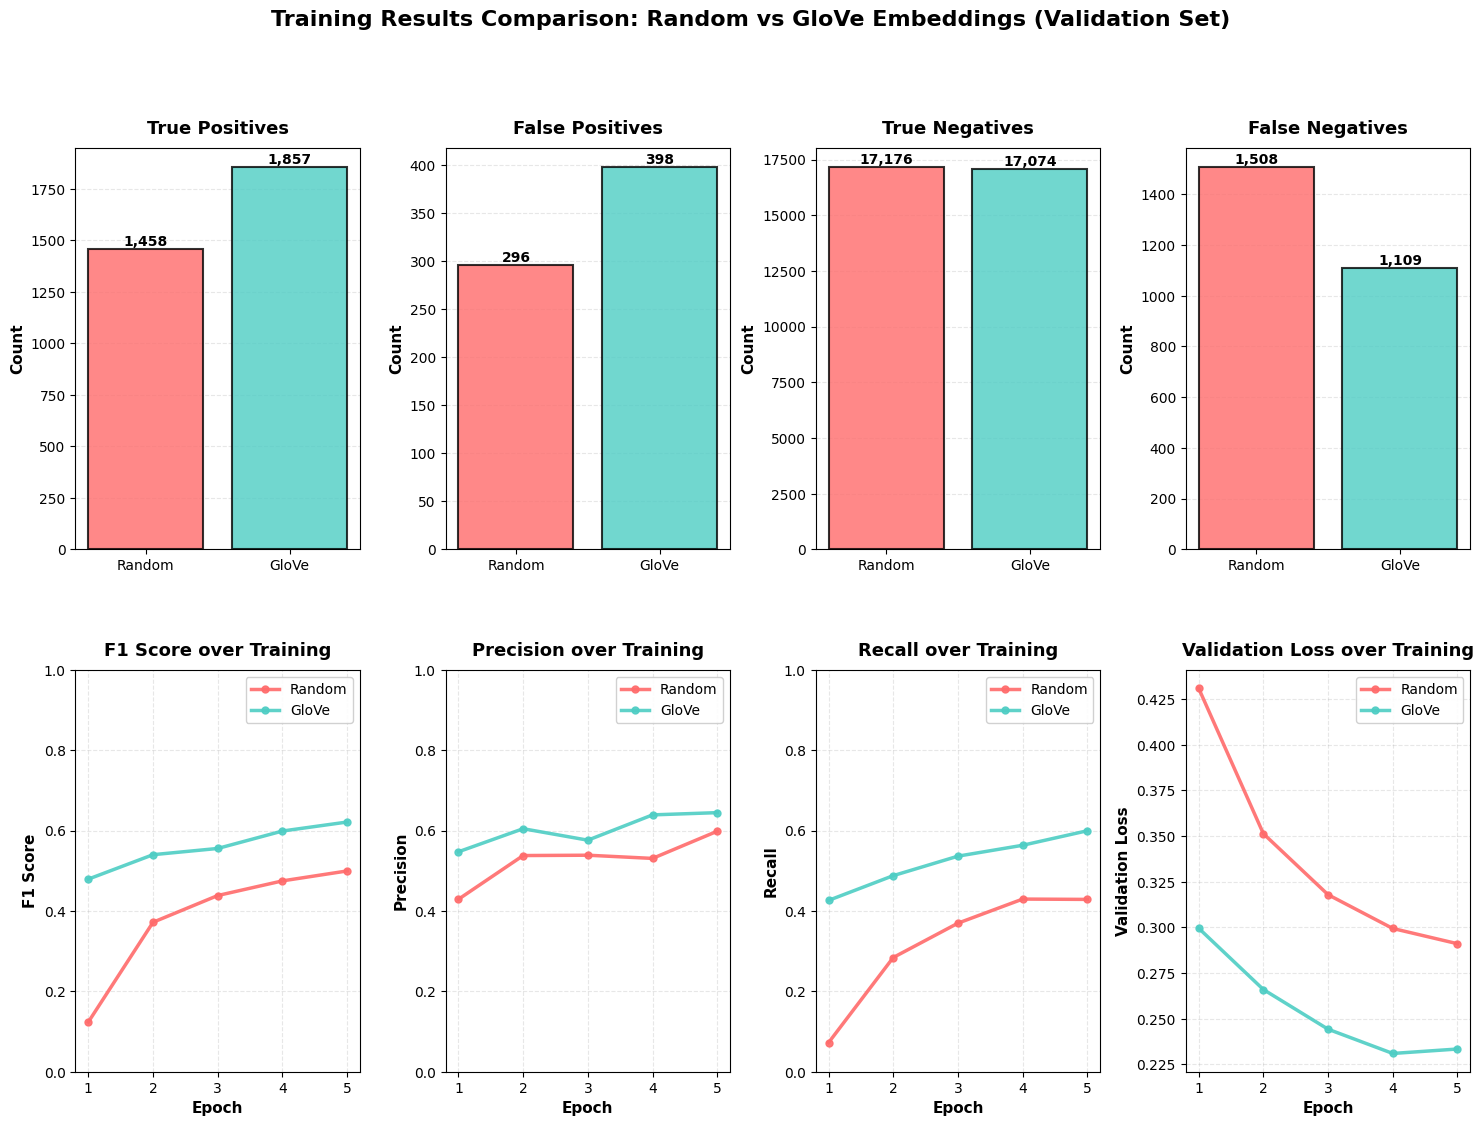


TOKEN-LEVEL CONFUSION MATRIX METRICS (VALIDATION SET)

Note: 'Positive' = Entity token, 'Negative' = 'O' (non-entity) token

                 TP   FP     TN    FN  Accuracy  Entity_Precision  Entity_Recall
BiLSTM_Random  1458  296  17176  1508  0.911733          0.831243       0.491571
BiLSTM_GloVe   1857  398  17074  1109  0.926265          0.823503       0.626096

--------------------------------------------------------------------------------
INTERPRETATION GUIDE
--------------------------------------------------------------------------------
TP (True Positives):  Correctly identified entity tokens
FP (False Positives): Incorrectly marked non-entity as entity
TN (True Negatives):  Correctly identified non-entity tokens
FN (False Negatives): Missed entity tokens (marked as non-entity)

✓ EXPECTED RESULTS (if models are working correctly):
   - TN should be ~87% of total tokens (most tokens are 'O')
   - TP should be much smaller than TN (entities are rare)
   - If TN=0, the bug is s

In [17]:
# =============================================================================
# COMPREHENSIVE RESULTS VISUALIZATION (VALIDATION SET)
# =============================================================================
# Visualize confusion matrix metrics and training history for both models
# This uses VALIDATION data (not test), so you can see results before testing

from sklearn.metrics import confusion_matrix
import itertools

print("=" * 80)
print("Evaluating models on VALIDATION set for visualization...")
print("=" * 80)

# Evaluate models on validation set to get predictions
validation_results = {}
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_IDX)

for model_name, results in training_results.items():
    print(f"\nEvaluating {model_name} on validation set...")
    model = results['model']
    
    # Load best model weights
    model_path = f'../results/{model_name}_best.pt'
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
    
    model.to(device)
    
    # Get predictions on validation set
    val_loss, val_f1, val_precision, val_recall, predictions, true_labels = evaluate(
        model, val_loader, criterion, device, idx2tag
    )
    
    validation_results[model_name] = {
        'predictions': predictions,
        'true_labels': true_labels,
        'f1': val_f1,
        'precision': val_precision,
        'recall': val_recall
    }
    print(f"  F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

print("\n" + "=" * 80 + "\n")

def calculate_confusion_metrics(true_labels, predictions):
    """
    Calculate token-level confusion matrix metrics (TP, FP, TN, FN).
    
    For NER, we treat 'O' (non-entity) as negative class and all entity tags as positive class.
    """
    # Flatten the nested lists
    y_true_flat = [tag for seq in true_labels for tag in seq]
    y_pred_flat = [tag for seq in predictions for tag in seq]
    
    # Convert to binary: 'O' = 0 (negative), anything else = 1 (positive/entity)
    y_true_binary = [0 if tag == 'O' else 1 for tag in y_true_flat]
    y_pred_binary = [0 if tag == 'O' else 1 for tag in y_pred_flat]
    
    # Calculate confusion matrix
    # Returns [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
    
    return {
        'TP': int(tp),  # True Positives: Correctly predicted entities
        'FP': int(fp),  # False Positives: Predicted entity but was 'O'
        'TN': int(tn),  # True Negatives: Correctly predicted 'O'
        'FN': int(fn)   # False Negatives: Predicted 'O' but was entity
    }

# Calculate confusion metrics for each model
confusion_metrics = {}
for model_name, results in validation_results.items():
    metrics = calculate_confusion_metrics(
        results['true_labels'], 
        results['predictions']
    )
    confusion_metrics[model_name] = metrics

# =============================================================================
# CREATE VISUALIZATION: 2x4 grid
# Row 1: Confusion Matrix Metrics (bar charts for TP, FP, TN, FN)
# Row 2: Training History (F1, Precision, Recall, Val Loss)
# =============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

# Color scheme for models
colors = {'BiLSTM_Random': '#FF6B6B', 'BiLSTM_GloVe': '#4ECDC4'}
model_names = list(training_results.keys())

# -----------------------------------------------------------------------------
# ROW 1: CONFUSION MATRIX METRICS
# -----------------------------------------------------------------------------

# Confusion metrics to plot
confusion_labels = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
confusion_keys = ['TP', 'FP', 'TN', 'FN']

for idx, (label, key) in enumerate(zip(confusion_labels, confusion_keys)):
    ax = fig.add_subplot(gs[0, idx])
    
    # Get values for each model
    values = [confusion_metrics[model][key] for model in model_names]
    model_colors = [colors.get(model, '#95a5a6') for model in model_names]
    
    # Create bar chart
    bars = ax.bar(range(len(model_names)), values, color=model_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:,}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Customize plot
    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_title(label, fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels([name.replace('BiLSTM_', '') for name in model_names], 
                       fontsize=10, rotation=0)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax.set_axisbelow(True)

# -----------------------------------------------------------------------------
# ROW 2: TRAINING HISTORY
# -----------------------------------------------------------------------------

# Training metrics to plot
history_metrics = [
    ('val_f1', 'F1 Score', [0, 1]),
    ('val_precision', 'Precision', [0, 1]),
    ('val_recall', 'Recall', [0, 1]),
    ('val_loss', 'Validation Loss', None)
]

for idx, (metric_key, metric_name, ylim) in enumerate(history_metrics):
    ax = fig.add_subplot(gs[1, idx])
    
    # Plot line for each model
    for model_name in model_names:
        history = training_results[model_name]['history']
        values = history[metric_key]
        epochs = range(1, len(values) + 1)
        
        model_color = colors.get(model_name, '#95a5a6')
        label = model_name.replace('BiLSTM_', '')
        
        # Plot with markers
        ax.plot(epochs, values, label=label, marker='o', markersize=5, 
                linewidth=2.5, color=model_color, alpha=0.9)
    
    # Customize plot
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric_name} over Training', fontsize=13, fontweight='bold', pad=10)
    ax.legend(fontsize=10, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Set y-axis limits if specified
    if ylim:
        ax.set_ylim(ylim)

# Add overall title
fig.suptitle('Training Results Comparison: Random vs GloVe Embeddings (Validation Set)', 
             fontsize=16, fontweight='bold', y=0.995)

# Save and show
plt.savefig('../results/comprehensive_comparison_validation.png', dpi=300, bbox_inches='tight')
print("=" * 80)
print("COMPREHENSIVE VISUALIZATION CREATED")
print("=" * 80)
print(f"\nSaved to: ../results/comprehensive_comparison_validation.png\n")
plt.show()

# -----------------------------------------------------------------------------
# PRINT DETAILED CONFUSION METRICS TABLE
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("TOKEN-LEVEL CONFUSION MATRIX METRICS (VALIDATION SET)")
print("=" * 80)
print("\nNote: 'Positive' = Entity token, 'Negative' = 'O' (non-entity) token\n")

# Create DataFrame for better formatting
confusion_df = pd.DataFrame(confusion_metrics).T
confusion_df = confusion_df[['TP', 'FP', 'TN', 'FN']]  # Reorder columns

# Calculate additional metrics
for model_name in confusion_df.index:
    tp = confusion_df.loc[model_name, 'TP']
    fp = confusion_df.loc[model_name, 'FP']
    tn = confusion_df.loc[model_name, 'TN']
    fn = confusion_df.loc[model_name, 'FN']
    
    # Token-level accuracy
    accuracy = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) > 0 else 0
    confusion_df.loc[model_name, 'Accuracy'] = accuracy
    
    # Entity detection rate
    entity_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    entity_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    confusion_df.loc[model_name, 'Entity_Precision'] = entity_precision
    confusion_df.loc[model_name, 'Entity_Recall'] = entity_recall

print(confusion_df.to_string())

# Print interpretation
print("\n" + "-" * 80)
print("INTERPRETATION GUIDE")
print("-" * 80)
print("TP (True Positives):  Correctly identified entity tokens")
print("FP (False Positives): Incorrectly marked non-entity as entity")
print("TN (True Negatives):  Correctly identified non-entity tokens")
print("FN (False Negatives): Missed entity tokens (marked as non-entity)")
print("\n✓ EXPECTED RESULTS (if models are working correctly):")
print("   - TN should be ~87% of total tokens (most tokens are 'O')")
print("   - TP should be much smaller than TN (entities are rare)")
print("   - If TN=0, the bug is still present - models never predict 'O'!")
print("=" * 80 + "\n")

## 14. Final Evaluation on Test Set

Load the best version of each model and evaluate on held-out test data.

**Why test on a separate set?**
- Validation set was used for hyperparameter tuning and model selection
- Test set provides an unbiased estimate of real-world performance
- Helps detect if we've overfit to the validation set

In [ ]:
# Create a comprehensive visualization of training progress
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Metrics to plot
metrics = [
    ('train_loss', 'Training Loss'),
    ('val_loss', 'Validation Loss'),
    ('val_f1', 'Validation F1 Score'),
    ('val_precision', 'Validation Precision')
]

# Plot each metric
for idx, (metric_key, metric_name) in enumerate(metrics):
    # Get subplot position (row, col)
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Plot line for each model
    for model_name, results in training_results.items():
        # Get metric values across epochs
        values = results['history'][metric_key]
        epochs = range(1, len(values) + 1)
        
        # Plot with marker for each epoch
        ax.plot(epochs, values, label=model_name, marker='o', markersize=4, linewidth=2)
    
    # Customize plot
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel(metric_name, fontsize=11)
    ax.set_title(metric_name, fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Set appropriate y-axis limits
    if 'loss' in metric_key.lower():
        ax.set_ylim(bottom=0)  # Loss starts from 0

# Add overall title
fig.suptitle('Training Progress: Embedding Comparison', fontsize=16, fontweight='bold', y=1.00)

# Save and show
plt.tight_layout()
os.makedirs('../results', exist_ok=True)
plt.savefig('../results/training_curves_embedding_comparison.png', dpi=300, bbox_inches='tight')
print(\"Training curves saved to: ../results/training_curves_embedding_comparison.png\")
plt.show()

# Print summary statistics
print(f\"\\n{'='*80}\")
print(\"TRAINING SUMMARY\")
print(f\"{'='*80}\")
for model_name, results in training_results.items():
    history = results['history']
    print(f\"\\n{model_name}:\")
    print(f\"  Final train loss:     {history['train_loss'][-1]:.4f}\")
    print(f\"  Final val loss:       {history['val_loss'][-1]:.4f}\")
    print(f\"  Final val F1:         {history['val_f1'][-1]:.4f}\")
    print(f\"  Best val F1:          {results['best_f1']:.4f}\")
    print(f\"  Final val precision:  {history['val_precision'][-1]:.4f}\")
    print(f\"  Final val recall:     {history['val_recall'][-1]:.4f}\")
print(f\"{'='*80}\\n\")

## 15. Compare Models

Create comparison tables and visualizations to understand the differences between random and GloVe embeddings.

**What to look for**:
- Which embedding strategy performs better overall?
- Are there specific entity types where one approach excels?
- What's the trade-off between performance and training time?

In [ ]:
# Initialize loss function for evaluation
# IMPORTANT FIX: Use PAD_TAG_IDX to match training
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_IDX)

# Store final test results
final_results = {}

print(f"{'='*80}")
print("FINAL EVALUATION ON TEST SET")
print(f"{'='*80}\n")

# Evaluate each model
for model_name, results in training_results.items():
    print(f"\n{'-'*80}")
    print(f"Model: {model_name}")
    print(f"{'-'*80}")
    
    # Load best model weights (saved during training)
    model = results['model']
    model_path = f'../results/{model_name}_best.pt'
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded best model from: {model_path}")
    else:
        print(f"Warning: Could not find saved model at {model_path}")
        print("Using current model state instead.")
    
    model.to(device)
    
    # Evaluate on test set
    test_loss, test_f1, test_precision, test_recall, predictions, true_labels = evaluate(
        model, test_loader, criterion, device, idx2tag
    )
    
    # Print overall metrics
    print(f"\nOverall Test Metrics:")
    print(f"  Test Loss:  {test_loss:.4f}")
    print(f"  F1 Score:   {test_f1:.4f}")
    print(f"  Precision:  {test_precision:.4f}")
    print(f"  Recall:     {test_recall:.4f}")
    
    # Print detailed classification report (per-entity metrics)
    print(f"\nDetailed Classification Report (Per-Entity Metrics):")
    print(classification_report(true_labels, predictions))
    
    # Store results for comparison
    final_results[model_name] = {
        'f1': test_f1,
        'precision': test_precision,
        'recall': test_recall,
        'loss': test_loss,
        'predictions': predictions,
        'true_labels': true_labels
    }

print(f"\n{'='*80}")
print("TEST EVALUATION COMPLETE")
print(f"{'='*80}\n")

## 16. Test on Custom Literary Text

Try both models on new literary text to see how they perform in practice.

**Purpose**:
- Qualitative evaluation: See if the models make sense
- Compare predictions between random and GloVe embeddings
- Test on classic literary examples

In [ ]:
# =============================================================================
# CREATE COMPARISON TABLE
# =============================================================================
# Extract metrics (excluding predictions and true_labels)
comparison_data = {
    model_name: {k: v for k, v in results.items() if k not in ['predictions', 'true_labels']}
    for model_name, results in final_results.items()
}

# Create DataFrame for easy comparison
comparison_df = pd.DataFrame(comparison_data).T
comparison_df = comparison_df.round(4)

print(f\"\\n{'='*80}\")
print(\"MODEL COMPARISON SUMMARY\")
print(f\"{'='*80}\\n\")
print(comparison_df)
print()

# Calculate and print the improvement/difference
if len(comparison_df) == 2:
    models_list = list(comparison_df.index)
    print(f\"\\nDifference (GloVe vs Random):\")
    for metric in ['f1', 'precision', 'recall']:
        if 'BiLSTM_GloVe' in models_list and 'BiLSTM_Random' in models_list:
            diff = comparison_df.loc['BiLSTM_GloVe', metric] - comparison_df.loc['BiLSTM_Random', metric]
            pct_change = (diff / comparison_df.loc['BiLSTM_Random', metric]) * 100
            print(f\"  {metric.capitalize():12s}: {diff:+.4f} ({pct_change:+.2f}%)\")

# Save to CSV
os.makedirs('../results', exist_ok=True)
comparison_df.to_csv('../results/embedding_comparison.csv')
print(f\"\\nComparison saved to: ../results/embedding_comparison.csv\")

# =============================================================================
# CREATE COMPARISON VISUALIZATIONS
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot comparing metrics
comparison_df[['f1', 'precision', 'recall']].plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].legend(['F1', 'Precision', 'Recall'], loc='lower right', fontsize=10)
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Radar/spider plot (if we have 2 models)
if len(comparison_df) >= 1:
    categories = ['F1', 'Precision', 'Recall']
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Close the circle
    
    ax = plt.subplot(122, projection='polar')
    for model_name in comparison_df.index:
        values = [
            comparison_df.loc[model_name, 'f1'],
            comparison_df.loc[model_name, 'precision'],
            comparison_df.loc[model_name, 'recall']
        ]
        values += values[:1]  # Close the circle
        ax.plot(angles, values, 'o-', linewidth=2, label=model_name)
        ax.fill(angles, values, alpha=0.15)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_title('Performance Metrics Radar Chart', fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
    ax.grid(True)

plt.tight_layout()
plt.savefig('../results/embedding_comparison_charts.png', dpi=300, bbox_inches='tight')
print(f\"Comparison charts saved to: ../results/embedding_comparison_charts.png\")
plt.show()

print(f\"\\n{'='*80}\")
print(\"COMPARISON COMPLETE\")
print(f\"{'='*80}\\n\")

## 17. Save Results Summary

Save all results to JSON for reproducibility and later reference. This includes:
- Dataset statistics
- Model configurations
- Hyperparameters used
- Final test metrics
- Training history

In [ ]:
def predict_ner(model, text, word2idx, idx2tag, device, max_len=128):
    """
    Predict NER tags for custom text.
    
    Args:
        model: Trained BiLSTM model
        text: Input text string
        word2idx: Word to index mapping
        idx2tag: Index to tag mapping
        device: torch device (CPU or GPU)
        max_len: Maximum sequence length (default=128)
    
    Returns:
        List of (token, tag) tuples
    """
    # Set model to evaluation mode
    model.eval()
    
    # Tokenize (simple whitespace split)
    # Note: In production, you'd use a more sophisticated tokenizer
    tokens = text.split()
    
    # Convert tokens to indices
    # Use <UNK> index for words not in vocabulary
    token_ids = [
        word2idx.get(token.lower(), word2idx['<UNK>']) 
        for token in tokens
    ]
    
    # Pad/truncate to max_len
    if len(token_ids) > max_len:
        token_ids = token_ids[:max_len]
        tokens = tokens[:max_len]
    else:
        padding_len = max_len - len(token_ids)
        token_ids = token_ids + [word2idx['<PAD>']] * padding_len
    
    # Create attention mask
    attention_mask = [1 if tid != word2idx['<PAD>'] else 0 for tid in token_ids]
    
    # Convert to tensors and add batch dimension
    input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)
    attention_mask_tensor = torch.tensor([attention_mask], dtype=torch.long).to(device)
    
    # Predict
    with torch.no_grad():
        logits = model(input_ids, attention_mask_tensor)
        predictions = torch.argmax(logits, dim=-1)
    
    # Convert predictions to tags
    pred_tags = [
        idx2tag.get(pred.item(), 'O') 
        for pred in predictions[0][:len(tokens)]
    ]
    
    return list(zip(tokens, pred_tags))


# =============================================================================
# TEST ON SAMPLE LITERARY TEXTS
# =============================================================================
# Sample texts from classic literature (include various entity types)
sample_texts = [
    \"Elizabeth Bennet lived in Longbourn with her family. Mr. Darcy owned Pemberley in Derbyshire.\",
    \"Sherlock Holmes resided at 221B Baker Street in London. Dr. Watson often accompanied him.\",
    \"Captain Ahab sailed the Pequod across the Atlantic Ocean in pursuit of Moby Dick.\",
    \"Jane Eyre arrived at Thornfield Hall to meet Mr. Rochester.\",
    \"Emma Woodhouse lived in Highbury near London. She often visited Donwell Abbey.\"
]

print(f\"{'='*80}\")
print(\"TESTING ON CUSTOM LITERARY TEXT\")
print(f\"{'='*80}\\n\")

# Test each sample text with all models
for text_idx, sample_text in enumerate(sample_texts, 1):
    print(f\"\\n{'-'*80}\")
    print(f\"Sample Text {text_idx}:\")
    print(f\"{'-'*80}\")
    print(f\"{sample_text}\")
    print()
    
    # Get predictions from all models
    for model_name, results in training_results.items():
        model = results['model']
        # Load best model
        model_path = f'../results/{model_name}_best.pt'
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path))
        model.to(device)
        
        # Predict
        predictions = predict_ner(model, sample_text, word2idx, idx2tag, device, MAX_LEN)
        
        # Display results
        print(f\"{model_name}:\")
        # Only show entities (non-'O' tags)
        entities = [(token, tag) for token, tag in predictions if tag != 'O']
        if entities:
            for token, tag in entities:
                print(f\"  {token:25s} → {tag}\")
        else:
            print(\"  (No entities detected)\")
        print()

print(f\"{'-'*80}\")
print(f\"\\n{'='*80}\")
print(\"CUSTOM TEXT TESTING COMPLETE\")
print(f\"{'='*80}\\n\")